In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

##### Scrape football player names from espn with their touchdowns from 2018

In [2]:
import requests
url = 'https://www.espn.com/nfl/stats/player/_/stat/receiving/season/2018/seasontype/2/table/receiving/sort/receivingYards/dir/desc'
page = requests.get(url)

from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
#print(soup.prettify())
table_data = soup.find('section', class_="ResponsiveTable ResponsiveTable--fixed-left mt4 Table2__title--remove-capitalization")
names = table_data.findAll('a', class_='AnchorLink')

##### Gather the names, hand size, and weights

In [48]:
regex = r'(?<=\">).*[a-zA-Z](?=\<)'
players = [re.search(regex,str(names[i]))[0] for i in range(15)]
wr = 14 #number of wide-receivers
touch_down = [re.findall(r'\d{1,4}',str(table_data.find_all('tr')[i]))[8] 
                                                          for i in range(52,52+wr)]
hand_size = [9.75, 10, 9.625, 9, 10.5, 10.5, 9, 9, 9.625, 9, 8.5, 9.25, 9.625]
weight = [220, 214, 225, 185, 216, 203, 216, 249, 201, 260, 186, 183, 194]

In [57]:
attributes = zip(players,touch_down,hand_size,weight)

player_data = {i: player for i,player in enumerate([[player,touchdown,hand_size,weight] 
                    for player,touchdown,hand_size,weight in (attributes)])
        }

player_df = pd.DataFrame.from_dict(player_data, orient='index',
                         columns=['Name','touchdowns','hand_size','weight']); player_df



,Name,touchdowns,hand_size,weight
0,Julio Jones,8,9.750,220
1,DeAndre Hopkins,11,10.000,214
2,Mike Evans,8,9.625,225
3,Tyreek Hill,12,9.000,185
4,JuJu Smith-Schuster,7,10.500,216
5,Michael Thomas,9,10.500,203
6,Davante Adams,13,9.000,216
7,George Kittle,5,9.000,249
8,Adam Thielen,9,9.625,201
9,Travis Kelce,10,9.000,260


##### Run a KNN model

In [63]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=1)

X = player_df[['hand_size', 'weight']]
Y = player_df.touchdowns
neighbors.fit(X,Y)

neighbors.predict([[10.5, 200]])

array(['9'], dtype=object)

##### Results:

For a hypothetical reciever with 10 1/2" hands and 200 pounds the model predicts he will have 9 touchdowns in a season.

In [66]:
neighbors = KNeighborsClassifier(n_neighbors=5)

neighbors.fit(X,Y)

neighbors.predict([[10.5, 200]])

array(['9'], dtype=object)

with n_neighbors set to 5 it predicts 9 touchdowns again

ValueError: RGBA values should be within 0-1 range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11970b378> (for post_execute):


TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

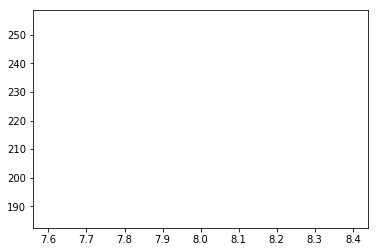

In [67]:
# Our data. Converting from data frames to arrays for the mesh.
X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()